In [1]:
import sys
import math
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

from Src import augment_image, \
        show_multiple_images_in_tf_data, \
        split_and_prepare_datasets, \
        processing_data_train_to_VGG_input, \
        processing_data_test_to_VGG_input, \
        show_multiple_images_with_label_pred_tf_data

from config import CLASSES_LIST, MODEL_PATH
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
sibi_train_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_train_dataset.tfrecord", compression="GZIP")
sibi_test_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_test_dataset.tfrecord", compression="GZIP")

In [12]:
print(f'info train data: {sibi_train_dataset_loaded}')
print(f'number of train data: {len(sibi_train_dataset_loaded)}')
print()
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of train data: 5200

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [13]:
sibi_train_dataset_augmented = sibi_train_dataset_loaded.map(augment_image)
sibi_train_dataset_cached = sibi_train_dataset_augmented.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 1)
    dtype-image: <dtype: 'float32'>
    max-intensity: 0.9935948848724365
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]
    original-label: Z
    label-shape: (26,)
    image-type: <dtype: 'float32'>


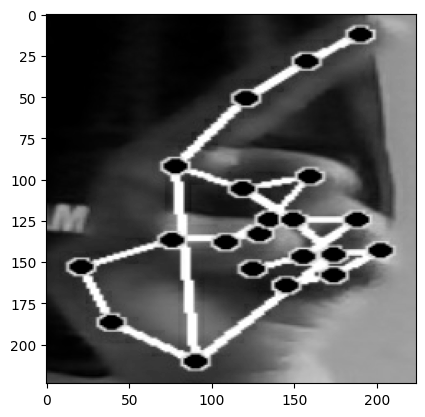

In [6]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_cached.shuffle(buffer_size=sibi_train_dataset_cached.cardinality().numpy()).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

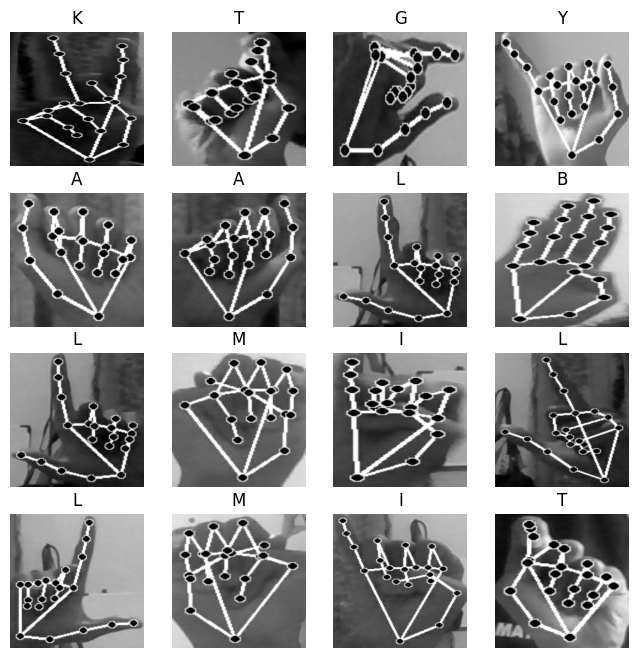

In [7]:
show_multiple_images_in_tf_data(sibi_train_dataset_cached, num_images=16, classes_list=CLASSES_LIST)

In [14]:
train_dataset_batched, valid_dataset_batched = split_and_prepare_datasets(sibi_train_dataset_cached, batch_size=32, train_split=0.9)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Training Split: 0.9
Number of data: 4680
AFTER BATCH: 32
Number of data: 147
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Validation Split: 0.1
Number of data: 520
AFTER BATCH: 32
Number of data: 17


In [15]:
sibi_train_dataset_3_channels = train_dataset_batched.map(processing_data_train_to_VGG_input)
sibi_valid_dataset_3_channels = valid_dataset_batched.map(processing_data_train_to_VGG_input)

sibi_train_dataset_3_channels_cached = sibi_train_dataset_3_channels.cache()
sibi_valid_dataset_3_channels_cached = sibi_valid_dataset_3_channels.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: N
    label-shape: (26,)
    image-type: <dtype: 'float32'>


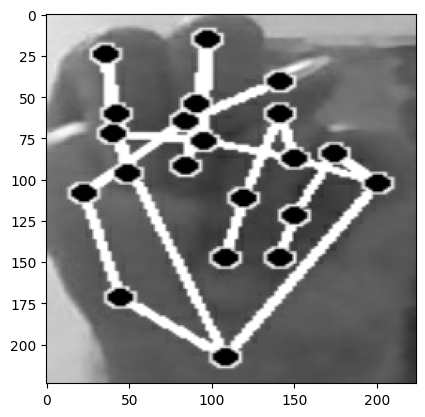

In [19]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_3_channels_cached.shuffle(buffer_size=sibi_train_dataset_3_channels_cached.cardinality().numpy()).take(1):
    image, label = image[0], label[0]
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

In [13]:
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [14]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
def build_model(input_shape=(224, 224, 3), loss=None, metrics=None, num_classes=None, base_model_trainable=False):
    input_layer = tf.keras.Input(shape=input_shape)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Pass the input through the base model
    x = base_model(input_layer, training=False)

    # Add global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add fully connected tf.keras.layers with dropout
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output layer with softmax activation
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=learning_rate_adam,
                  loss=loss,
                  metrics=metrics)

    return model

learning_rate_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy() # https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
# If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True.
metrics = ['accuracy']

model = build_model(input_shape=(224, 224, 3), loss=loss, metrics=metrics, num_classes=len(CLASSES_LIST), base_model_trainable=False)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,046,362 (57.40 MB)

 Trainable params: 331,674 (1.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
target_path_keras_model = '../Assets/Model/SIBI_effecientnetb0_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=target_path_keras_model,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=25,
  restore_best_weights=True,
  verbose=1
)

history = model.fit(
    sibi_train_dataset_3_channels_cached,
    validation_data=sibi_valid_dataset_3_channels_cached,
    epochs=300,
    callbacks=[
    plateau_callback,
    early_stopping,
    checkpoint_callback
  ]
)

In [3]:
best_model = tf.keras.models.load_model(MODEL_PATH)

In [23]:
# Evaluasi model yang dimuat
loaded_evaluation = best_model.evaluate(sibi_valid_dataset_3_channels_cached)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 163s 10s/step - accuracy: 0.9990 - loss: 0.0074
Evaluation on validation data (loaded model): [0.02110341750085354, 0.9961538314819336]


In [22]:
def evaluate_model(model, test_dataset, class_names):
  """
  Evaluate the model using confusion matrix, classification report, and other metrics.
  
  Args:
  - model: Trained Keras model.
  - test_dataset: tf.data.Dataset for evaluation.
  - class_names: List of class names corresponding to the labels.
  """
  # Extract the true labels and predicted labels
  y_true = []
  y_pred = []

  for images, labels in test_dataset:
      predictions = model.predict(images, verbose=0)
      y_true.extend(np.argmax(labels.numpy(), axis=1))
      y_pred.extend(np.argmax(predictions, axis=1))

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Display confusion matrix with class names
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # Print classification report with class names
  print("Classification Report:")
  print(classification_report(y_true, y_pred))


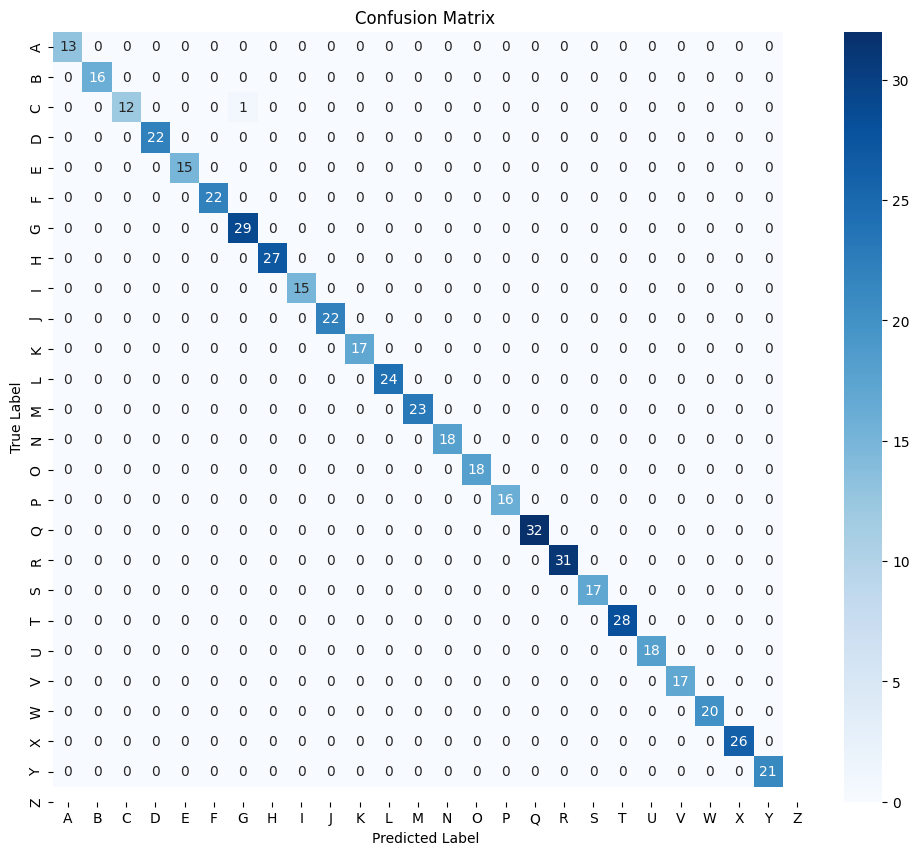

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16
           2       1.00      0.92      0.96        13
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        22
           6       0.97      1.00      0.98        29
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        18
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        32
    

In [23]:
evaluate_model(best_model, sibi_valid_dataset_3_channels_cached, CLASSES_LIST)

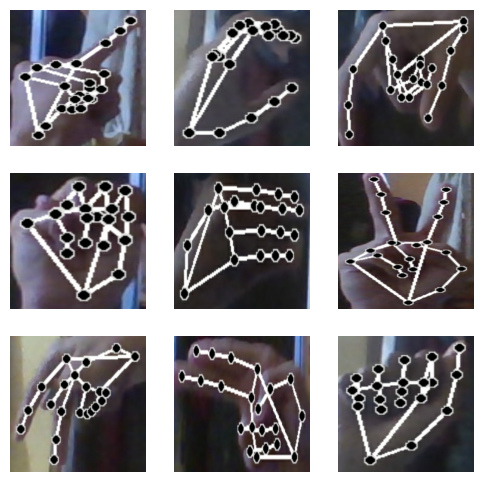

In [5]:
show_multiple_images_in_tf_data(sibi_test_dataset_loaded, num_images=9)

In [6]:
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [5]:
sibi_test_dataset_loaded_rgb = sibi_test_dataset_loaded.map(processing_data_test_to_VGG_input)
sibi_test_dataset_loaded_rgb_cached = sibi_test_dataset_loaded_rgb.cache()

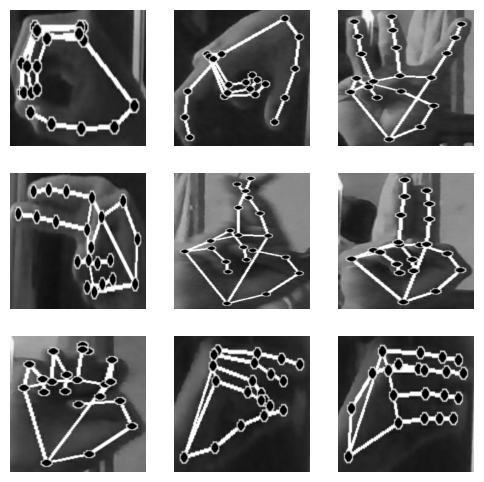

In [8]:
show_multiple_images_in_tf_data(sibi_test_dataset_loaded_rgb_cached, num_images=9)

In [9]:
print(f'info test data: {sibi_test_dataset_loaded_rgb_cached}')
print(f'number of test data: {len(sibi_test_dataset_loaded_rgb_cached)}')

info test data: <CacheDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


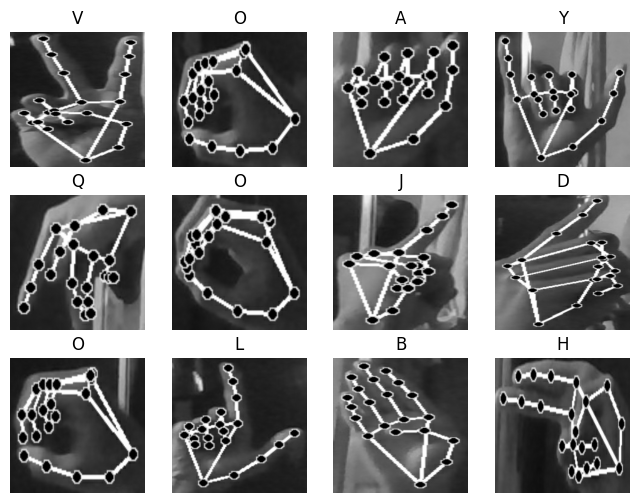

In [6]:
show_multiple_images_with_label_pred_tf_data(model=best_model, dataset=sibi_test_dataset_loaded_rgb_cached, num_images=12, figsize_per_image=(2, 2), classes_list=CLASSES_LIST)